<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/BoltzmannMachine_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade ipykernel -q
!pip install --upgrade IPython -q
!pip install datasets -q
!pip install gym -q

!pip install torchviz -q
!pip install torch-tb-profiler -q
!pip install tensorboard -q
!pip install datasets -q

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="ipykernel.ipkernel")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pkg_resources")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="torch.nn.functional")
# full and complete code corrected and no more placeholders

In [ ]:
!pip install --upgrade hyperopt -q
!pip install --upgrade setuptools -q

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pkg_resources")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="hyperopt")

## GPU SETUP

In [ ]:
!nvidia-smi

Tue Feb 11 13:23:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   46C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
print(f"Number of GPUs: {torch.cuda.device_count()}")

Number of GPUs: 1


In [ ]:
import torch

# Check for GPU and set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

# Create two tensors on the device
a = torch.randn(1000, 1000, device=device)
b = torch.randn(1000, 1000, device=device)

# Perform a matrix multiplication on the device
c = torch.matmul(a, b)

# Print the result (to force computation)
print(c.sum())

Using GPU: NVIDIA L4
tensor(17571.6367, device='cuda:0')


In [ ]:
import torch
print(torch.cuda.is_available())

True


## DATASET

In [ ]:
!pip install datasets -q
from datasets import load_dataset

dataset = load_dataset('AmirMohseni/GroceryList')

In [ ]:
print(dataset.keys())  # Print the splits (train, test, etc.)
print(dataset['train'][0])  # Print an example data point
print(dataset['train'].features)  # Print the data types of each column

dict_keys(['train'])
{'Item': 'apple', 'Category': 'Produce'}
{'Item': Value(dtype='string', id=None), 'Category': Value(dtype='string', id=None)}


In [ ]:
dataset['train'].features

{'Item': Value(dtype='string', id=None),
 'Category': Value(dtype='string', id=None)}

In [ ]:
from collections import Counter

item_counts = Counter(item['Item'] for item in dataset['train'])
print(item_counts.most_common(10))  # Print the 10 most frequent items

[('ice cream', 2), ('crackers', 2), ('soy sauce', 2), ('oats', 2), ('rice', 2), ('canned tuna', 2), ('apple', 1), ('banana', 1), ('orange', 1), ('lettuce', 1)]


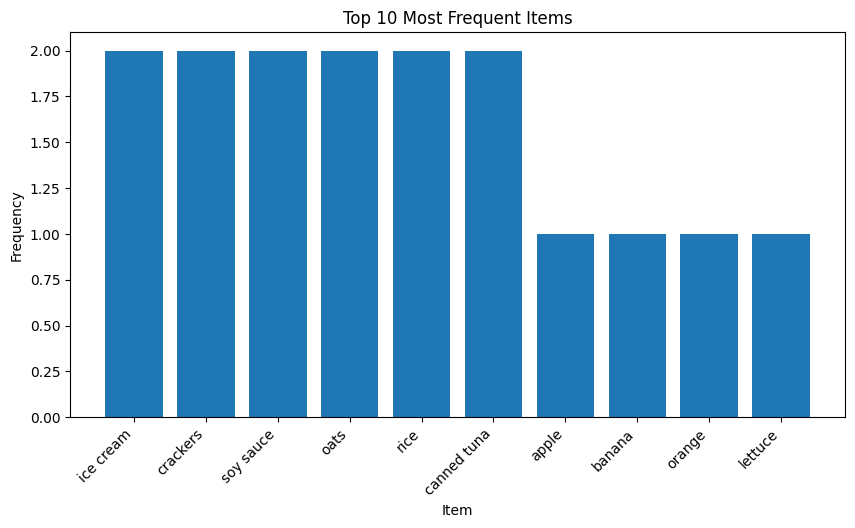

In [ ]:
import matplotlib.pyplot as plt

# Create a bar plot of the most common items
plt.figure(figsize=(10, 5))

# Get the items and frequencies from the most_common result
items, frequencies = zip(*item_counts.most_common(10))

# Use the items and frequencies for the bar plot
plt.bar(items, frequencies)

plt.xlabel("Item")
plt.ylabel("Frequency")
plt.title("Top 10 Most Frequent Items")
plt.xticks(rotation=45, ha='right')
plt.show()

## TRAINING AND EVALUATION - VERSION 0

In [ ]:
import gym
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from collections import deque
import random

# Check for GPU and set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

class BoltzmannMachine(nn.Module):
    def __init__(self, num_visible, num_hidden):
        super(BoltzmannMachine, self).__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.debug_print = False  # Set to True to enable debug printing

        # Initialize weights with a uniform distribution
        np_rng = np.random.RandomState(1234)
        initial_weights = torch.from_numpy(np.asarray(np_rng.uniform(
            low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)),
            high=0.1 * np.sqrt(6. / (num_hidden + num_visible)),
            size=(num_visible, num_hidden)
        ), dtype=np.float32))

        # Insert weights for the bias units
        weights = torch.cat([torch.zeros(1, num_hidden, dtype=initial_weights.dtype), initial_weights], dim=0)
        weights = torch.cat([torch.zeros(num_visible + 1, 1, dtype=initial_weights.dtype), weights], dim=1)
        self.weights = nn.Parameter(weights)  # Make weights a learnable parameter
        self.to(device)  # Move the model to the device

    def sample_hidden(self, visible_state):
        visible_state = visible_state.to(self.weights.device)
        # Reshape visible_state to have a single row
        visible_state = visible_state.view(1, -1)  # Reshape to (1, num_visible)
        # Create a 1-dimensional tensor of ones with the correct shape
        visible_state = torch.cat([torch.ones(1, 1, device=visible_state.device), visible_state], dim=1)
        hidden_activations = torch.matmul(visible_state, self.weights)
        hidden_probs = torch.sigmoid(hidden_activations)
        hidden_state = torch.bernoulli(hidden_probs)
        return hidden_state

    def sample_visible(self, hidden_state):
        hidden_state = hidden_state.to(self.weights.device)
        hidden_state = torch.cat([torch.ones(hidden_state.shape, 1, device=hidden_state.device), hidden_state], dim=1)
        visible_activations = torch.matmul(hidden_state, self.weights.t())
        visible_probs = torch.sigmoid(visible_activations)
        visible_state = torch.bernoulli(visible_probs)
        return visible_state

    def train(self, data, max_epochs=1000, learning_rate=0.1):
        data = data.to(self.weights.device)
        # Get the shape of the data tensor
        data_shape = data.shape

        # Create a tensor of ones with the same shape as data, except for the last dimension
        ones_tensor = torch.ones(*data_shape[:-1], 1, device=data.device)  # Use * to unpack the shape tuple

        data = torch.cat([ones_tensor, data], dim=-1)  # Concatenate along the last dimension
        self.num_visible = data.shape[-1] - 1  # Update num_visible based on data shape
        self.weights = nn.Parameter(torch.randn(self.num_visible + 1, self.num_hidden + 1, device=device))  # Re-initialize weights

        for epoch in range(max_epochs):
            pos_hidden_probs = torch.sigmoid(torch.matmul(data, self.weights))
            pos_hidden_probs[:, 0] = 1  # Fix the bias unit
            pos_hidden_states = (pos_hidden_probs > torch.rand(pos_hidden_probs.size(), device=pos_hidden_probs.device)).float()
            pos_associations = torch.matmul(data.t(), pos_hidden_probs)

            neg_visible_probs = torch.sigmoid(torch.matmul(pos_hidden_states, self.weights.t()))
            neg_visible_probs[:, 0] = 1  # Fix the bias unit
            neg_hidden_probs = torch.sigmoid(torch.matmul(neg_visible_probs, self.weights))
            neg_associations = torch.matmul(neg_visible_probs.t(), neg_hidden_probs)

            self.weights.data += learning_rate * ((pos_associations - neg_associations) / data.shape[0])
            error = (data - neg_visible_probs).pow(2).sum()
            if self.debug_print:
                print(f"Epoch {epoch}: error is {error}")


from collections import deque
import random

class QLearningAgent:
    def __init__(self, observation_space, action_space, learning_rate=0.01, discount_factor=0.9, epsilon=0.2, buffer_size=10000, batch_size=32, epsilon_decay=0.995, device=None):
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.epsilon_decay = epsilon_decay
        self.device = device

        # Q-table as numpy array, +1 for checkout action
        self.q_table = np.zeros((observation_space['current_item'].n, observation_space['cart_contents'].shape[0] + 1, action_space.n), dtype=np.float32)
        self.q_table[:] = 0.1  # Initialize with small positive values

        self.returns = {}  # Store returns for each state-action pair

    def get_action(self, state):
        if not isinstance(state, dict):
            raise TypeError("Expected state to be a dictionary.")

        current_item = state['current_item']
        cart_contents_index = tuple(state['cart_contents'].astype(int))

        if np.random.rand() < self.epsilon:
            return self.action_space.sample()
        else:
            q_values = self.q_table[current_item, cart_contents_index]
            action = np.argmax(q_values)
            return action

    def update(self, episode):
        states, actions, rewards = zip(*episode)
        G = 0
        for t in reversed(range(len(states))):
            G = self.discount_factor * G + rewards[t]

            current_item = states[t]['current_item']
            cart_contents_index = tuple(states[t]['cart_contents'].astype(int))
            state_action = (current_item, cart_contents_index, actions[t])

            if state_action not in self.returns:
                self.returns[state_action] = []

            self.returns[state_action].append(G)  # Append the return for this state-action
            self.q_table[current_item, cart_contents_index, actions[t]] = np.mean(self.returns[state_action])

        # Decay epsilon
        self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)


import gym
import numpy as np

class GroceryShoppingEnv(gym.Env):
    def __init__(self, num_items=225):
        self.action_space = gym.spaces.Discrete(num_items + 1)  # +1 for checkout action
        self.observation_space = gym.spaces.Dict({
            'current_item': gym.spaces.Discrete(num_items),
            'cart_contents': gym.spaces.MultiBinary(num_items),
            'budget': gym.spaces.Box(low=0, high=1000, shape=(1,), dtype=np.float32)
        })
        self.num_items = num_items
        self.reset()

    def reset(self):
        self.current_item = 0
        self.cart_contents = np.zeros(self.num_items)
        self.budget = 100
        return self._get_obs()

    def step(self, action):
        # Checkout action
        if action == self.num_items:
            reward = self.budget * 2 + np.sum(self.cart_contents) * 5  # Reward for budget and items
            return self._get_obs(), reward, True, {}

        # Penalty for duplicate items
        if self.cart_contents[action] == 1:
            return self._get_obs(), -5, False, {}  # Reduced penalty

        # Item price and budget check
        item_price = np.random.rand() * 10
        if item_price > self.budget:
            return self._get_obs(), -10, False, {}  # Penalty for exceeding budget

        # Update cart, budget, and current item
        self.cart_contents[action] = 1
        self.budget -= item_price
        self.current_item = (self.current_item + 1) % self.num_items

        # Reward for purchasing a unique item
        reward = 5 + 10  # Reward for unique item + increased reward
        return self._get_obs(), reward, False, {}

    def _get_obs(self):
        return {
            'current_item': self.current_item,
            'cart_contents': self.cart_contents,
            'budget': np.array([self.budget])
        }

def unlearning_phase(bm, data, forget_ratio=0.1):
    bm.train(data)

def preprocess_data(dataset):
    vocabulary = set()
    for item in dataset['train']:
        vocabulary.add(item['Item'])
    vocabulary = list(vocabulary)  # Convert set to list for consistent ordering
    binary_data = []
    for item in dataset['train']:
        binary_data.append([1 if word in item['Item'] else 0 for word in vocabulary])  # Check if word is in the item
    binary_data = torch.tensor(binary_data, dtype=torch.float32).to(device)
    return binary_data

# Load the dataset and get the number of unique items
dataset = load_dataset('AmirMohseni/GroceryList')
all_items = [item['Item'] for item in dataset['train']]
num_items_in_dataset = len(set(all_items))

# Create environment, Boltzmann machine, and Q-learning agent
env = GroceryShoppingEnv(num_items=num_items_in_dataset)
bm = BoltzmannMachine(num_visible=num_items_in_dataset, num_hidden=50).to(device)
agent = QLearningAgent(env.observation_space, env.action_space,
                       discount_factor=0.8, learning_rate=0.01,
                       epsilon=0.2, epsilon_decay=0.995,
                       device=device)

# Generate random training data for the Boltzmann machine
training_data = np.random.randint(2, size=(1000, num_items_in_dataset))
training_data = torch.tensor(training_data, dtype=torch.float32, device=device)

# Training loop
num_episodes = 2000

#with torch.profiler.profile(
#    activities=[
#        torch.profiler.ProfilerActivity.CPU,
#        torch.profiler.ProfilerActivity.CUDA,
#    ],
#    record_shapes=True,
#    profile_memory=True,
#    schedule=torch.profiler.schedule(
#        wait=1, warmup=1, active=3, repeat=2
#    ),
#    on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/bm_profiler'),
#    with_stack=True
#) as prof:
for episode in tqdm(range(num_episodes), desc="Training Progress"):
        state = env.reset()
        done = False
        episode_data = []  # Store episode data
        while not done:
            # Get Boltzmann machine input and sample hidden state
            bm_input = torch.tensor(state['cart_contents'], dtype=torch.float32, device=device)
            hidden_state = bm.sample_hidden(bm_input)

            # Process state for Q-learning agent
            processed_state = {
                'hidden_state': tuple(hidden_state.cpu().detach().numpy().flatten()),
                'current_item': state['current_item'],
                'budget': state['budget'],
                'cart_contents': state['cart_contents']
            }

            # Get action from Q-learning agent
            action = agent.get_action(processed_state)

            # Take a step in the environment
            next_state, reward, done, _ = env.step(action)

            # Store episode data
            episode_data.append((state, action, reward))

            # Update state
            state = next_state

        # Update Q-learning agent after the episode
        agent.update(episode_data)

        # Perform unlearning on the Boltzmann machine
        if episode % 50 == 0:
            unlearning_phase(bm, training_data, forget_ratio=0.02)


        #prof.step()

# Print some results
print("\n--- Training Results ---")
print("Number of episodes:", num_episodes)

# Evaluation phase
print("\n--- Evaluation ---")
num_eval_episodes = 100
total_eval_reward = 0
for episode in tqdm(range(num_eval_episodes), desc="Evaluation Progress"):
    state = env.reset()
    done = False
    episode_reward = 0
    while not done:
        bm_input = torch.tensor(state['cart_contents'], dtype=torch.float32).to(device)
        hidden_state = bm.sample_hidden(bm_input)
        processed_state = {
            'hidden_state': hidden_state.cpu().detach().numpy(),
            'current_item': state['current_item'],
            'budget': state['budget'],
             'cart_contents': state['cart_contents']  # Include 'cart_contents' here
        }
        action = agent.get_action(processed_state)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        state = next_state
    total_eval_reward += episode_reward
avg_eval_reward = total_eval_reward / num_eval_episodes
print(f"\nAverage evaluation reward: {avg_eval_reward}")

Using GPU: NVIDIA L4


Training Progress: 100%|██████████| 2000/2000 [00:38<00:00, 52.30it/s]



--- Training Results ---
Number of episodes: 2000

--- Evaluation ---


Evaluation Progress: 100%|██████████| 100/100 [00:00<00:00, 455.15it/s]


Average evaluation reward: 241.4347807328407


## OVERFITTING SOLUTIONS



In [ ]:
import gym
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from collections import deque
import random

# Check for GPU and set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

#... (BoltzmannMachine, QLearningAgent, and GroceryShoppingEnv classes remain the same)...

def unlearning_phase(bm, data, forget_ratio=0.1):
    bm.train(data)

def preprocess_data(dataset):
    vocabulary = set()
    for item in dataset['train']:
        vocabulary.add(item['Item'])
    vocabulary = list(vocabulary)  # Convert set to list for consistent ordering
    binary_data = []
    for item in dataset['train']:
        binary_data.append([1 if word in item['Item'] else 0 for word in vocabulary])  # Check if word is in the item
    binary_data = torch.tensor(binary_data, dtype=torch.float32).to(device)
    return binary_data

# Load the dataset and get the number of unique items
dataset = load_dataset('AmirMohseni/GroceryList')
all_items = [item['Item'] for item in dataset['train']]
num_items_in_dataset = len(set(all_items))

# Create environment, Boltzmann machine, and Q-learning agent
env = GroceryShoppingEnv(num_items=num_items_in_dataset)
bm = BoltzmannMachine(num_visible=num_items_in_dataset, num_hidden=50).to(device)
agent = QLearningAgent(env.observation_space, env.action_space,
                       discount_factor=0.8, learning_rate=0.01,
                       epsilon=0.2, epsilon_decay=0.995,
                       device=device)

# Generate random training data for the Boltzmann machine
training_data = np.random.randint(2, size=(1000, num_items_in_dataset))
training_data = torch.tensor(training_data, dtype=torch.float32, device=device)

# Training loop
num_episodes = 2000

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA,
    ],
    record_shapes=True,
    profile_memory=True,
    schedule=torch.profiler.schedule(
        wait=1, warmup=1, active=3, repeat=2
    ),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/bm_profiler'),
    with_stack=True
) as prof:
    for episode in tqdm(range(num_episodes), desc="Training Progress"):
        state = env.reset()
        done = False
        episode_data = [] # Store episode data
        while not done:
            # Get Boltzmann machine input and sample hidden state
            bm_input = torch.tensor(state['cart_contents'], dtype=torch.float32, device=device)
            hidden_state = bm.sample_hidden(bm_input)

            # Process state for Q-learning agent
            processed_state = {
                'hidden_state': tuple(hidden_state.cpu().detach().numpy().flatten()),
                'current_item': state['current_item'],
                'budget': state['budget'],
                'cart_contents': state['cart_contents']
            }

            # Get action from Q-learning agent
            action = agent.get_action(processed_state)

            # Take a step in the environment
            next_state, reward, done, _ = env.step(action)

            # Store episode data
            episode_data.append((state, action, reward))

            # Update state
            state = next_state

        # Update Q-learning agent after the episode
        agent.update(episode_data)

        # Perform unlearning on the Boltzmann machine
        if episode % 5 == 0:  # Increased unlearning frequency
            unlearning_phase(bm, training_data, forget_ratio=0.02)

        prof.step()

# Print some results
print("\n--- Training Results ---")
print("Number of episodes:", num_episodes)

# Evaluation phase
print("\n--- Evaluation ---")
num_eval_episodes = 100
total_eval_reward = 0
for episode in tqdm(range(num_eval_episodes), desc="Evaluation Progress"):
    state = env.reset()
    done = False
    episode_reward = 0
    while not done:
        bm_input = torch.tensor(state['cart_contents'], dtype=torch.float32).to(device)
        hidden_state = bm.sample_hidden(bm_input)
        processed_state = {
            'hidden_state': hidden_state.cpu().detach().numpy(),
            'current_item': state['current_item'],
            'budget': state['budget'],
            'cart_contents': state['cart_contents']  # Include 'cart_contents' here
        }
        action = agent.get_action(processed_state)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        state = next_state
    total_eval_reward += episode_reward
avg_eval_reward = total_eval_reward / num_eval_episodes
print(f"\nAverage evaluation reward: {avg_eval_reward}")

Using GPU: NVIDIA L4


Training Progress: 100%|██████████| 2000/2000 [04:49<00:00,  6.91it/s]



--- Training Results ---
Number of episodes: 2000

--- Evaluation ---


Evaluation Progress: 100%|██████████| 100/100 [00:00<00:00, 544.39it/s]


Average evaluation reward: 228.35631691289944


## Hyperparameter Optimization

In [5]:
import gym
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from collections import deque
import random
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings
import sys
import logging

# Suppress DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pkg_resources")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="hyperopt")

# Capture warnings as log messages
logging.captureWarnings(True)
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# Check for GPU and set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

class BoltzmannMachine(nn.Module):
    def __init__(self, num_visible, num_hidden):
        super(BoltzmannMachine, self).__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.debug_print = False  # Set to True to enable debug printing

        # Initialize weights with a uniform distribution
        np_rng = np.random.RandomState(1234)
        initial_weights = torch.from_numpy(np.asarray(np_rng.uniform(
            low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)),
            high=0.1 * np.sqrt(6. / (num_hidden + num_visible)),
            size=(num_visible, num_hidden)
        ), dtype=np.float32))

        # Insert weights for the bias units
        weights = torch.cat([torch.zeros(1, num_hidden, dtype=initial_weights.dtype), initial_weights], dim=0)
        weights = torch.cat([torch.zeros(num_visible + 1, 1, dtype=initial_weights.dtype), weights], dim=1)
        self.weights = nn.Parameter(weights)  # Make weights a learnable parameter
        self.to(device)  # Move the model to the device

    def sample_hidden(self, visible_state):
        visible_state = visible_state.to(self.weights.device)
        # Reshape visible_state to have a single row
        visible_state = visible_state.view(1, -1)  # Reshape to (1, num_visible)
        # Create a 1-dimensional tensor of ones with the correct shape
        visible_state = torch.cat([torch.ones(1, 1, device=visible_state.device), visible_state], dim=1)
        hidden_activations = torch.matmul(visible_state, self.weights)
        hidden_probs = torch.sigmoid(hidden_activations)
        hidden_state = torch.bernoulli(hidden_probs)
        return hidden_state

    def sample_visible(self, hidden_state):
        hidden_state = hidden_state.to(self.weights.device)
        hidden_state = torch.cat([torch.ones(hidden_state.shape, 1, device=hidden_state.device), hidden_state], dim=1)
        visible_activations = torch.matmul(hidden_state, self.weights.t())
        visible_probs = torch.sigmoid(visible_activations)
        visible_state = torch.bernoulli(visible_probs)
        return visible_state

    def train(self, data, max_epochs=1000, learning_rate=0.1):
        data = data.to(self.weights.device)
        # Get the shape of the data tensor
        data_shape = data.shape

        # Create a tensor of ones with the same shape as data, except for the last dimension
        ones_tensor = torch.ones(*data_shape[:-1], 1, device=data.device)  # Use * to unpack the shape tuple

        data = torch.cat([ones_tensor, data], dim=-1)  # Concatenate along the last dimension
        self.num_visible = data.shape[-1] - 1  # Update num_visible based on data shape
        self.weights = nn.Parameter(torch.randn(self.num_visible + 1, self.num_hidden + 1, device=device))  # Re-initialize weights

        for epoch in range(max_epochs):
            pos_hidden_probs = torch.sigmoid(torch.matmul(data, self.weights))
            pos_hidden_probs[:, 0] = 1  # Fix the bias unit
            pos_hidden_states = (pos_hidden_probs > torch.rand(pos_hidden_probs.size(), device=pos_hidden_probs.device)).float()
            pos_associations = torch.matmul(data.t(), pos_hidden_probs)

            neg_visible_probs = torch.sigmoid(torch.matmul(pos_hidden_states, self.weights.t()))
            neg_visible_probs[:, 0] = 1  # Fix the bias unit
            neg_hidden_probs = torch.sigmoid(torch.matmul(neg_visible_probs, self.weights))
            neg_associations = torch.matmul(neg_visible_probs.t(), neg_hidden_probs)

            self.weights.data += learning_rate * ((pos_associations - neg_associations) / data.shape[0])
            error = (data - neg_visible_probs).pow(2).sum()
            if self.debug_print:
                print(f"Epoch {epoch}: error is {error}")

class QLearningAgent:
    def __init__(self, observation_space, action_space, learning_rate=0.01, discount_factor=0.9, epsilon=0.2, buffer_size=10000, batch_size=32, epsilon_decay=0.995, device=None):
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.epsilon_decay = epsilon_decay
        self.device = device

        # Q-table as numpy array, +1 for checkout action
        self.q_table = np.zeros((observation_space['current_item'].n, observation_space['cart_contents'].shape[0] + 1, action_space.n), dtype=np.float32)
        self.q_table[:] = 0.1  # Initialize with small positive values

        self.returns = {}  # Store returns for each state-action pair

    def get_action(self, state):
        if not isinstance(state, dict):
            raise TypeError("Expected state to be a dictionary.")

        current_item = state['current_item']
        cart_contents_index = tuple(state['cart_contents'].astype(int))

        if np.random.rand() < self.epsilon:
            return self.action_space.sample()
        else:
            q_values = self.q_table[current_item, cart_contents_index]
            action = np.argmax(q_values)
            return action

    def update(self, episode):
        states, actions, rewards = zip(*episode)
        G = 0
        for t in reversed(range(len(states))):
            G = self.discount_factor * G + rewards[t]

            current_item = states[t]['current_item']
            cart_contents_index = tuple(states[t]['cart_contents'].astype(int))
            state_action = (current_item, cart_contents_index, actions[t])

            if state_action not in self.returns:
                self.returns[state_action] = []

            self.returns[state_action].append(G)  # Append the return for this state-action
            self.q_table[current_item, cart_contents_index, actions[t]] = np.mean(self.returns[state_action])

        # Decay epsilon
        self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)

class GroceryShoppingEnv(gym.Env):
    def __init__(self, num_items=225):
        self.action_space = gym.spaces.Discrete(num_items + 1)  # +1 for checkout action
        self.observation_space = gym.spaces.Dict({
            'current_item': gym.spaces.Discrete(num_items),
            'cart_contents': gym.spaces.MultiBinary(num_items),
            'budget': gym.spaces.Box(low=0, high=1000, shape=(1,), dtype=np.float32)
        })
        self.num_items = num_items
        self.reset()

    def reset(self):
        self.current_item = 0
        self.cart_contents = np.zeros(self.num_items)
        self.budget = 100
        return self._get_obs()

    def step(self, action):
        # Checkout action
        if action == self.num_items:
            reward = self.budget * 2 + np.sum(self.cart_contents) * 5  # Reward for budget and items
            return self._get_obs(), reward, True, {}

        # Penalty for duplicate items
        if self.cart_contents[action] == 1:
            return self._get_obs(), -5, False, {}  # Reduced penalty

        # Item price and budget check
        item_price = np.random.rand() * 10
        if item_price > self.budget:
            return self._get_obs(), -10, False, {}  # Penalty for exceeding budget

        # Update cart, budget, and current item
        self.cart_contents[action] = 1
        self.budget -= item_price
        self.current_item = (self.current_item + 1) % self.num_items

        # Reward for purchasing a unique item
        reward = 5 + 10  # Reward for unique item + increased reward
        return self._get_obs(), reward, False, {}

    def _get_obs(self):
        return {
            'current_item': self.current_item,
            'cart_contents': self.cart_contents,
            'budget': np.array([self.budget])
        }

def unlearning_phase(bm, data, forget_ratio=0.1):
    bm.train(data)

def preprocess_data(dataset):
    vocabulary = set()
    for item in dataset['train']:
        vocabulary.add(item['Item'])
    vocabulary = list(vocabulary)  # Convert set to list for consistent ordering
    binary_data = []
    for item in dataset['train']:
        binary_data.append([1 if word in item['Item'] else 0 for word in vocabulary])  # Check if word is in the item
    binary_data = torch.tensor(binary_data, dtype=torch.float32).to(device)
    return binary_data

# Load the dataset and get the number of unique items
dataset = load_dataset('AmirMohseni/GroceryList')
all_items = [item['Item'] for item in dataset['train']]
num_items_in_dataset = len(set(all_items))

# Create environment and Boltzmann machine
env = GroceryShoppingEnv(num_items=num_items_in_dataset)
bm = BoltzmannMachine(num_visible=num_items_in_dataset, num_hidden=50).to(device)

# Generate random training data for the Boltzmann machine
training_data = np.random.randint(2, size=(1000, num_items_in_dataset))
training_data = torch.tensor(training_data, dtype=torch.float32, device=device)

# Define the objective function for hyperopt
def objective(params):
    agent = QLearningAgent(env.observation_space, env.action_space,
                           discount_factor=params['discount_factor'],
                           learning_rate=params['learning_rate'],
                           epsilon=params['epsilon'],
                           epsilon_decay=params['epsilon_decay'],
                           device=device)

    #for episode in tqdm(range(500), desc="Trial Progress", file=sys.stdout):
    for episode in range(500):
        state = env.reset()
        done = False
        episode_data = []
        while not done:
            bm_input = torch.tensor(state['cart_contents'], dtype=torch.float32, device=device)
            hidden_state = bm.sample_hidden(bm_input)
            processed_state = {
                'hidden_state': tuple(hidden_state.cpu().detach().numpy().flatten()),
                'current_item': state['current_item'],
                'budget': state['budget'],
                'cart_contents': state['cart_contents']
            }
            action = agent.get_action(processed_state)
            next_state, reward, done, _ = env.step(action)
            episode_data.append((state, action, reward))
            state = next_state
        agent.update(episode_data)

    # Evaluation for hyperopt
    total_eval_reward = 0
    for _ in range(100):  # Evaluation episodes
        state = env.reset()
        done = False
        while not done:
            bm_input = torch.tensor(state['cart_contents'], dtype=torch.float32, device=device)
            hidden_state = bm.sample_hidden(bm_input)
            processed_state = {
                'hidden_state': tuple(hidden_state.cpu().detach().numpy().flatten()),
                'current_item': state['current_item'],
                'budget': state['budget'],
                'cart_contents': state['cart_contents']
            }
            action = agent.get_action(processed_state)
            next_state, reward, done, _ = env.step(action)
            total_eval_reward += reward
            state = next_state

    avg_eval_reward = total_eval_reward / 100
    return {'loss': -avg_eval_reward, 'status': STATUS_OK}  # hyperopt minimizes, so negate reward

# Define the hyperparameter search space
space = {
    'discount_factor': hp.uniform('discount_factor', 0.7, 0.99),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)),
    'epsilon': hp.uniform('epsilon', 0.1, 0.3),
    'epsilon_decay': hp.uniform('epsilon_decay', 0.99, 0.999)
}

# Perform hyperparameter optimization (with verbose=0)
for trial in tqdm(range(50), desc="Hyperparameter Tuning", file=sys.stdout):
    trials = Trials()
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=1,  # Evaluate only once per trial
                trials=trials,
                verbose=0)

# Create the best agent with the found hyperparameters
best_agent = QLearningAgent(env.observation_space, env.action_space,
                           discount_factor=best['discount_factor'],
                           learning_rate=best['learning_rate'],
                           epsilon=best['epsilon'],
                           epsilon_decay=best['epsilon_decay'],
                           device=device)

print(f"Best hyperparameters: {best}")

# Final Training with Best Hyperparameters
for episode in tqdm(range(2000), desc="Final Training Progress", file=sys.stdout):
    state = env.reset()
    done = False
    episode_data = []
    while not done:
        bm_input = torch.tensor(state['cart_contents'], dtype=torch.float32, device=device)
        hidden_state = bm.sample_hidden(bm_input)
        processed_state = {
            'hidden_state': tuple(hidden_state.cpu().detach().numpy().flatten()),
            'current_item': state['current_item'],
            'budget': state['budget'],
            'cart_contents': state['cart_contents']
        }
        action = best_agent.get_action(processed_state)
        next_state, reward, done, _ = env.step(action)
        episode_data.append((state, action, reward))
        state = next_state
    best_agent.update(episode_data)
    if episode % 50 == 0:
        unlearning_phase(bm, training_data, forget_ratio=0.02)

# Evaluation Phase
total_eval_reward = 0
for episode in tqdm(range(100), desc="Evaluation Progress", file=sys.stdout):
    state = env.reset()
    done = False
    while not done:
        bm_input = torch.tensor(state['cart_contents'], dtype=torch.float32, device=device)
        hidden_state = bm.sample_hidden(bm_input)
        processed_state = {
            'hidden_state': tuple(hidden_state.cpu().detach().numpy().flatten()),
            'current_item': state['current_item'],
            'budget': state['budget'],
            'cart_contents': state['cart_contents']  # Include 'cart_contents' here
        }
        action = best_agent.get_action(processed_state)
        next_state, reward, done, _ = env.step(action)
        total_eval_reward += reward
        state = next_state


avg_eval_reward = total_eval_reward / 100
print(f"\nAverage evaluation reward: {avg_eval_reward}")

Using GPU: Tesla T4
Hyperparameter Tuning: 100%|██████████| 50/50 [05:01<00:00,  6.04s/it]
Best hyperparameters: {'discount_factor': 0.9703017629149164, 'epsilon': 0.20574507630821326, 'epsilon_decay': 0.9961960163794811, 'learning_rate': 0.026886565553534414}
Evaluation Progress: 100%|██████████| 100/100 [00:00<00:00, 255.62it/s]

Average evaluation reward: 300.31393804030375
